In [8]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import re

from collections import defaultdict

In [9]:
UNK = '<UNK>'
PAD = '<PAD>'

In [10]:
data = pd.read_csv('data/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
# Check if the data is balanced. ok

len(data[data['sentiment']=='positive'])

25000

In [12]:
# create the vocabulary

long_string = ' '.join(data['review'].values).lower()
chars_to_drop = list('.')
for c in chars_to_drop:
    long_string = long_string.replace(c, '')

chars_to_replace = list(' ,\'<>\/*"()!?$#@+-%=&_;:{}`[]^')
for c in chars_to_replace:
    long_string = long_string.replace(c, ' ')

long_string, num_stripped = re.subn('[0-9]+', '<NUM> ', long_string)
print(f'encoded {num_stripped} numbers')

encoded 76846 numbers


In [13]:
vocab = set([UNK])
vocab.update(long_string.split())
len(vocab)

114642

In [15]:
# Create the lookup tables for encoding the words and stuff PAD in there at 0

index_to_word = {k+1:v for k, v in enumerate(vocab)}
index_to_word[0] = PAD
word_to_index = defaultdict(None, {v:k for k, v in index_to_word.items()})

In [16]:
index_to_word[0]

'<PAD>'

In [17]:
# Take a look at the longest review

data['max_length'] = data['review'].map(lambda x: len(x.split()))
print(data.loc[np.argmax(data['max_length'])].review)

Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, but

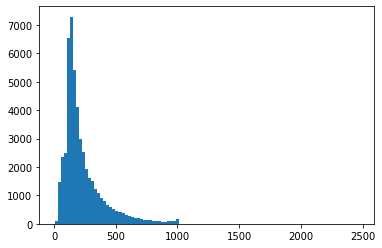

In [18]:
# Histogram of review lengths in words
# Mostly capped at 1000
_ = plt.hist(data['max_length'], bins=100)
plt.show()

In [19]:
# Only a small number over 1000, so we wil se this as our max length
data[data['max_length']>1000].sort_values('max_length')

,review,sentiment,max_length
28629,I have never seen any of Spike Lee's prior fil...,negative,1001
24578,I read several mixed reviews and several of th...,positive,1001
20987,"This film grabbed me right from its start, whe...",positive,1001
20429,This review contains spoilers. I didn't have a...,negative,1001
29604,I really don't think producer George Lucas did...,negative,1001
...,...,...,...
12647,Titanic directed by James Cameron presents a f...,positive,1839
31240,"(Some spoilers included:)<br /><br />Although,...",positive,2108
31436,"Back in the mid/late 80s, an OAV anime by titl...",positive,2125
40521,There's a sign on The Lost Highway that says:<...,positive,2278


In [185]:
MAX_REVIEW_LENGTH = 150

In [186]:
# Map all words to indices up to our max length

def encode_review(review):
    encoded_review = [word_to_index.get(word, word_to_index[UNK]) for word in review.lower().split()[:MAX_REVIEW_LENGTH]]

    if len(encoded_review)<MAX_REVIEW_LENGTH:
        return (MAX_REVIEW_LENGTH - len(encoded_review))*[word_to_index[PAD]] + encoded_review
    else:
        return encoded_review

encoded_reviews = [encode_review(line) for line in data['review'].to_list() ]

In [187]:
# Create X and y

X = np.array(encoded_reviews)
y = np.array([1 if x=='positive' else 0 for x in data['sentiment'].to_list() ])

In [188]:
# split to train and test data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
list(map(np.shape, [X_train, X_test, y_train, y_test]))

[(37500, 150), (12500, 150), (37500,), (12500,)]

In [189]:
# Try fit a linear model for unprocessed features (very unlikely, 1000 features)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [190]:
# Use PCA to limit to 50 components

from sklearn.decomposition import PCA
p = PCA(n_components=50)
X_transformed = p.fit_transform(X)

In [191]:
# The explained variance is spread pretty widely. We are unlikely to get anything out of this

p.explained_variance_ratio_

array([0.14351566, 0.03754634, 0.01532895, 0.01071348, 0.00838333,
       0.00730967, 0.00688362, 0.0063805 , 0.00624199, 0.00622566,
       0.00619256, 0.00617198, 0.00614467, 0.00611184, 0.00609883,
       0.00609719, 0.00605999, 0.00604571, 0.00603751, 0.00602384,
       0.00600549, 0.00597596, 0.00596294, 0.0059366 , 0.00592594,
       0.00589388, 0.00588525, 0.00587486, 0.00585435, 0.00584114,
       0.00580475, 0.00579097, 0.00578794, 0.00576764, 0.00574243,
       0.00572959, 0.00571637, 0.00571461, 0.00568206, 0.00566234,
       0.00565111, 0.0056328 , 0.00561183, 0.00558248, 0.00556844,
       0.0055388 , 0.00552857, 0.00550524, 0.00548935, 0.00546776])

In [192]:
X_transformed.shape

(50000, 50)

In [193]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_transformed, y)
list(map(np.shape, [X_pca_train, X_pca_test, y_pca_train, y_pca_test]))

[(37500, 50), (12500, 50), (37500,), (12500,)]

In [194]:
lr.fit(X_pca_train, y_pca_train)

LogisticRegression()

In [195]:
# A linear model on the 50 'best' PCA components is pretty much random guessing
lr.score(X_pca_test, y_pca_test)

0.51344

In [32]:
# Simple network

def get_model():
    model = keras.models.Sequential()
    model.add(layers.Embedding(input_dim=len(vocab), output_dim=256, input_length=X.shape[1]))
    model.add(layers.Flatten())    
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 256)         29348352  
_________________________________________________________________
flatten (Flatten)            (None, 256000)            0         
_________________________________________________________________
dense (Dense)                (None, 200)               51200200  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 80,548,954
Trainable params: 80,548,954
Non-trainable params: 0
_________________________________________________________________


In [173]:
def get_sequence_model():
    model = keras.models.Sequential()
    model.add(layers.Embedding(input_dim=len(vocab), output_dim=16, input_length=X.shape[1]))
#     model.add(layers.Flatten())    
    model.add(layers.Bidirectional(layers.LSTM(32)))
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    
    return model

In [206]:
model = get_sequence_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 150, 16)           1834272   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 14        
Total params: 1,847,220
Trainable params: 1,847,220
Non-trainable params: 0
_________________________________________________________________


In [207]:
model.compile(loss=keras.losses.CategoricalCrossentropy(), 
              optimizer=keras.optimizers.Adam(), 
              metrics=[keras.metrics.CategoricalAccuracy()])

In [208]:
# max_train_size = 10000

# X_train = X[:max_train_size]
# X_test = X[max_train_size:max_train_size+int(.1*max_train_size)]

# y_train = y[:max_train_size]
# y_test = y[max_train_size:max_train_size+int(.1*max_train_size)]

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [210]:
CHECKPOINT_DIR = 'data/model/sentiment'

Epoch 1/50
1172/1172 [==============================] - 57s 47ms/step - loss: 0.5645 - categorical_accuracy: 0.6712 - val_loss: 0.3830 - val_categorical_accuracy: 0.8380


INFO:tensorflow:Assets written to: data/model/sentiment/assets


INFO:tensorflow:Assets written to: data/model/sentiment/assets


Epoch 2/50
1172/1172 [==============================] - 53s 46ms/step - loss: 0.2673 - categorical_accuracy: 0.8957 - val_loss: 0.3737 - val_categorical_accuracy: 0.8494


INFO:tensorflow:Assets written to: data/model/sentiment/assets


INFO:tensorflow:Assets written to: data/model/sentiment/assets


Epoch 3/50
1172/1172 [==============================] - 55s 47ms/step - loss: 0.1695 - categorical_accuracy: 0.9369 - val_loss: 0.4172 - val_categorical_accuracy: 0.8385


INFO:tensorflow:Assets written to: data/model/sentiment/assets


INFO:tensorflow:Assets written to: data/model/sentiment/assets


Epoch 4/50
1172/1172 [==============================] - 56s 48ms/step - loss: 0.1088 - categorical_accuracy: 0.9619 - val_loss: 0.6070 - val_categorical_accuracy: 0.8307


INFO:tensorflow:Assets written to: data/model/sentiment/assets


INFO:tensorflow:Assets written to: data/model/sentiment/assets


Epoch 5/50
1172/1172 [==============================] - 56s 48ms/step - loss: 0.0706 - categorical_accuracy: 0.9756 - val_loss: 0.6420 - val_categorical_accuracy: 0.8309


INFO:tensorflow:Assets written to: data/model/sentiment/assets


INFO:tensorflow:Assets written to: data/model/sentiment/assets


Epoch 6/50
1172/1172 [==============================] - 56s 48ms/step - loss: 0.0483 - categorical_accuracy: 0.9835 - val_loss: 0.6708 - val_categorical_accuracy: 0.8287


INFO:tensorflow:Assets written to: data/model/sentiment/assets


INFO:tensorflow:Assets written to: data/model/sentiment/assets


Epoch 7/50
1172/1172 [==============================] - 54s 46ms/step - loss: 0.0358 - categorical_accuracy: 0.9880 - val_loss: 0.7923 - val_categorical_accuracy: 0.8212


INFO:tensorflow:Assets written to: data/model/sentiment/assets


INFO:tensorflow:Assets written to: data/model/sentiment/assets


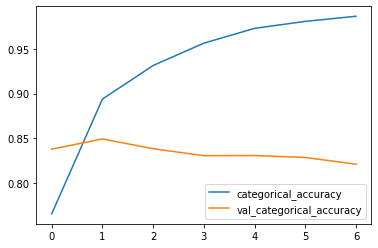

In [211]:
history = model.fit(X_train, keras.utils.to_categorical(y_train),
                    validation_data=(X_test, keras.utils.to_categorical(y_test)), 
                    batch_size=32, 
                    epochs=50, 
                    callbacks=[keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", patience=5),
                              keras.callbacks.ModelCheckpoint(CHECKPOINT_DIR, monitor="val_categorical_accuracy", save_only_best=True)])

plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.legend()
plt.show()

In [170]:
(np.argmax(model.predict(X_test[:100].reshape(1,-1)), axis = 1)==y_test[:100]).mean()

0.49

In [2]:
model = keras.models.load_model('data/model/sentiment')
model.summary()

In [166]:
predictions = []

In [167]:
predictions.append(model.predict(np.array(encode_review(data['review'][3])).reshape(1,-1)))
predictions

[array([[0.50145644]], dtype=float32)]

In [72]:
y_test[:10]

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [78]:
data['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."